In [ ]:
import json
import pandas as pd
import numpy as np
import re
from datetime import datetime
from scipy.stats import pearsonr
from scipy.spatial.distance import cosine
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import spacy
from collections import Counter, defaultdict
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from nltk.tree import Tree

In [ ]:
# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('taggers/averaged_perceptron_tagger')
    nltk.data.find('chunkers/maxent_ne_chunker')
    nltk.data.find('corpora/words')
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('punkt')
    nltk.download('averaged_perceptron_tagger')
    nltk.download('maxent_ne_chunker')
    nltk.download('words')
    nltk.download('stopwords')


class EnhancedInnovationTrendAnalyzer:
    """
    Enhanced Innovation Trend Analysis focusing on meaningful technical terms
    Extracts noun phrases, technical concepts, and domain-specific terminology
    """

    def __init__(self, file_path, time_window='yearly', min_patents_per_period=5):
        """
        Initialize Enhanced Innovation Trend Analyzer

        Args:
            file_path: Path to JSONL patent data file
            time_window: 'yearly', 'quarterly', or custom period in months
            min_patents_per_period: Minimum patents required per time period
        """
        self.file_path = file_path
        self.time_window = time_window
        self.min_patents_per_period = min_patents_per_period

        # Core data structures
        self.data = None
        self.processed_texts = None
        self.time_periods = []
        self.period_data = {}

        # NLP components
        self.nlp = None
        self.stop_words = set(stopwords.words('english'))
        self.custom_stopwords = {
            'within', 'wherein', 'thereof', 'therein', 'whereby', 'thereby',
            'herein', 'among', 'wherein', 'upon', 'thereafter', 'therefrom',
            'wherefrom', 'hereby', 'therewith', 'hereafter', 'herewith'
        }
        self.stop_words.update(self.custom_stopwords)


        # Technical term filters
        # Enhanced generic_terms - expanded to catch more patent boilerplate
        self.generic_terms = {
            # Basic patent language
            'method', 'system', 'apparatus', 'device', 'process', 'means',
            'step', 'using', 'determine', 'generate', 'generating', 'provide',
            'include', 'perform', 'obtain', 'receive', 'send', 'configured',
            'based', 'plurality', 'corresponding', 'associated', 'related',
            'first', 'second', 'third', 'one', 'two', 'three', 'embodiment',
            'invention', 'patent', 'claim', 'figure', 'example', 'present',
            'disclosure', 'described', 'accordance', 'aspect', 'particular',

            # Generic verb-noun combinations that appear meaningless
            'provide instruction', 'receive signal', 'determine output', 'process data',
            'generate information', 'obtain data', 'perform operation', 'include step',
            'configure system', 'execute instruction', 'store information',

            # Generic prepositional phrases
            'in accordance with', 'with respect to', 'in order to', 'based on',
            'corresponding to', 'associated with', 'related to', 'configured to',

            # Patent boilerplate instruction phrases
            'instructions cause', 'executable instructions', 'program instructions',
            'computer instructions', 'medium instructions', 'thereon instructions',
            'stored instructions', 'software instructions', 'code instructions',

            # Generic data/output terms
            'output data', 'input data', 'data output', 'data input', 'information data',
            'output information', 'input information', 'data stream', 'data flow',

            # Generic temporal terms
            'time information', 'time data', 'time duration', 'time period', 'time interval',
            'current time', 'predetermined time', 'specific time',

            # Keep AV-specific generic terms but make them more targeted
            # (removing overly broad terms like 'vehicle', 'driving' that might filter good compounds)
            'automobile', 'auto', 'transport', 'transportation'
        }

        # Analysis components
        self.meaningful_terms = {}
        self.noun_phrases = {}
        self.technical_concepts = {}
        self.domain_terms = {}

        # Results storage
        self.trending_terms = {}
        self.declining_terms = {}
        self.trending_concepts = {}
        self.declining_concepts = {}
        self.applicant_trends = {}
        self.technology_evolution = {}

        # Initialize NLP pipeline
        self._initialize_nlp()

        print("=== ENHANCED INNOVATION TREND ANALYZER INITIALIZED ===")
        print(f"Time window: {time_window}")
        print(f"Minimum patents per period: {min_patents_per_period}")

    def _initialize_nlp(self):
        """Initialize spaCy NLP pipeline"""
        try:
            # Try to load English model
            self.nlp = spacy.load("en_core_web_sm")
            print("spaCy English model loaded successfully")
        except OSError:
            print("spaCy English model not found. Please install with:")
            print("python -m spacy download en_core_web_sm")
            print("Falling back to NLTK-based processing...")
            self.nlp = None

    def load_data(self, file_path):
        """Load and parse JSONL file"""
        print("Loading patent data...")
        data = []
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                data.append(json.loads(line.strip()))

        df = pd.DataFrame(data)
        print(f"Loaded {len(df)} patents")
        return df

    def extract_meaningful_terms_spacy(self, text):
      """Extract meaningful terms using spaCy"""
      if not self.nlp or not text:
          return []

      doc = self.nlp(text)
      candidates = set()

      # Extract noun chunks (these preserve proper word order)
      for chunk in doc.noun_chunks:
          phrase = chunk.text.lower().strip()
          if 2 <= len(phrase.split()) <= 4 and len(phrase) > 5:
              if not any(generic in phrase for generic in self.generic_terms):
                  candidates.add(phrase)

      # Extract compound terms - FIXED: preserve head-child relationship order
      for token in doc:
          if token.pos_ == 'NOUN' and token.head.pos_ in {'ADJ', 'NOUN'}:
              # Check dependency relation to preserve correct order
              if token.dep_ in {'compound', 'amod'}:  # token modifies head
                  head = token.head.text.lower()
                  child = token.text.lower()
                  compound = f"{child} {head}"  # modifier comes first
              else:  # head modifies token
                  head = token.head.text.lower()
                  child = token.text.lower()
                  compound = f"{head} {child}"  # head comes first

              if len(compound.split()) == 2 and len(compound) > 6:
                  if not any(generic in compound for generic in self.generic_terms):
                      candidates.add(compound)

      # Named entities: Only include useful short entities
      for ent in doc.ents:
          if ent.label_ in {'ORG', 'PRODUCT', 'TECH'} and len(ent.text.split()) <= 3:
              ent_text = ent.text.lower().strip()
              if not any(generic in ent_text for generic in self.generic_terms):
                  candidates.add(ent_text)

      return list(candidates)

    def extract_meaningful_terms_nltk(self, text):
        """Extract meaningful terms using NLTK (fallback)"""
        if not text:
            return []

        tokens = word_tokenize(text.lower())
        pos_tags = pos_tag(tokens)
        candidates = set()

        # Extract noun phrase sequences (e.g. [JJ]* [NN]+)
        current_phrase = []
        for word, pos in pos_tags:
            if pos.startswith('JJ') or pos.startswith('NN'):
                current_phrase.append(word)
            else:
                if 2 <= len(current_phrase) <= 4:
                    phrase = ' '.join(current_phrase)
                    if len(phrase) > 5 and not any(generic in phrase for generic in self.generic_terms):
                        candidates.add(phrase)
                current_phrase = []
        # Final phrase at the end
        if 2 <= len(current_phrase) <= 4:
            phrase = ' '.join(current_phrase)
            if len(phrase) > 5 and not any(generic in phrase for generic in self.generic_terms):
                candidates.add(phrase)

        # Extract technical compound patterns
        for i in range(len(pos_tags) - 1):
            word1, pos1 = pos_tags[i]
            word2, pos2 = pos_tags[i + 1]
            if ((pos1.startswith('NN') and pos2.startswith('NN')) or
                (pos1.startswith('JJ') and pos2.startswith('NN')) or
                (pos1.startswith('NN') and pos2 == 'VBG')):

                compound = f"{word1} {word2}"
                if len(compound) > 6 and not any(generic in compound for generic in self.generic_terms):
                    candidates.add(compound)

        return list(candidates)

    def extract_domain_specific_terms(self, text):
        """Extract domain-specific technical terms"""
        domain_patterns = {
            # Perception & Sensing - expanded with variations
            'perception': r'\b(lidar|li-dar|light detection ranging|radar|radio detection|'
                        r'camera system|vision system|stereo camera|mono camera|'
                        r'ultrasonic sensor|sonar|stereo vision|binocular vision|'
                        r'depth estimation|depth perception|distance measurement|'
                        r'object detection|target detection|obstacle detection|'
                        r'lane detection|lane recognition|road marking detection|'
                        r'traffic sign recognition|sign detection|signal recognition|'
                        r'pedestrian detection|person detection|human detection|'
                        r'cyclist detection|bicycle detection|bike detection|'
                        r'semantic segmentation|pixel classification|scene parsing|'
                        r'instance segmentation|object segmentation|'
                        r'point cloud|3d point cloud|laser scan|lidar scan|'
                        r'sensor fusion|multi sensor|data fusion|information fusion|'
                        r'multi-modal sensing|multimodal perception|'
                        r'occupancy grid|occupancy map|grid map|voxel grid|3d grid)\b',

            # Localization & Mapping - with abbreviations
            'localization': r'\b(simultaneous localization mapping|slam|visual slam|v-slam|'
                          r'lidar slam|l-slam|visual odometry|vo|stereo odometry|'
                          r'gps rtk|rtk gps|real time kinematic|differential gps|dgps|'
                          r'high definition map|hd map|high precision map|detailed map|'
                          r'localization accuracy|pose accuracy|position accuracy|'
                          r'map matching|route matching|path matching|'
                          r'dead reckoning|inertial navigation|ins|'
                          r'particle filter|monte carlo|kalman filter|extended kalman|'
                          r'loop closure|place recognition|relocalization|'
                          r'pose estimation|position estimation|orientation estimation|'
                          r'global localization|local localization)\b',

            # Path Planning & Control - expanded control terms
            'planning_control': r'\b(path planning|route planning|trajectory planning|'
                              r'motion planning|behavioral planning|strategic planning|'
                              r'route optimization|path optimization|trajectory optimization|'
                              r'decision making|behavior planning|maneuver planning|'
                              r'steering control|lateral control|longitudinal control|'
                              r'throttle control|acceleration control|speed control|'
                              r'brake control|braking control|deceleration control|'
                              r'pid controller|proportional integral|model predictive control|'
                              r'mpc|linear quadratic|lqr|optimal control|'
                              r'collision avoidance|obstacle avoidance|crash avoidance|'
                              r'emergency braking|automatic emergency|aeb|'
                              r'lane keeping|lane centering|lane following|'
                              r'adaptive cruise control|acc|cruise control|'
                              r'trajectory tracking|path following|reference tracking)\b',

            # AI/ML for AV - updated with latest architectures
            'av_ai': r'\b(deep neural network|dnn|convolutional neural|cnn|convnet|'
                  r'recurrent neural|rnn|lstm|gru|transformer model|'
                  r'vision transformer|vit|attention mechanism|self attention|'
                  r'reinforcement learning|rl|deep reinforcement|drl|'
                  r'imitation learning|behavioral cloning|inverse reinforcement|'
                  r'end to end learning|e2e learning|end-to-end|'
                  r'supervised learning|unsupervised learning|semi supervised|'
                  r'transfer learning|domain adaptation|fine tuning|'
                  r'adversarial training|generative adversarial|gan|'
                  r'generative model|variational autoencoder|vae|'
                  r'graph neural network|gnn|graph convolution|'
                  r'temporal modeling|sequence modeling|time series|'
                  r'sequence prediction|future prediction|motion prediction)\b',

            # V2X Communication - expanded protocols
            'v2x': r'\b(vehicle to vehicle|v2v|car to car|c2c|'
                  r'vehicle to infrastructure|v2i|vehicle to roadside|v2r|'
                  r'vehicle to everything|v2x|vehicle to cloud|v2c|'
                  r'vehicle to pedestrian|v2p|vehicle to network|v2n|'
                  r'dedicated short range|dsrc|wave|ieee 802.11p|'
                  r'cellular v2x|c-v2x|lte v2x|5g v2x|nr v2x|'
                  r'5g communication|lte communication|cellular communication|'
                  r'cooperative driving|coordinated driving|collaborative driving|'
                  r'platooning|convoy|vehicle following|'
                  r'vehicle coordination|traffic coordination|fleet coordination|'
                  r'intersection management|traffic light|signal phase|'
                  r'connected vehicle|connected car|iot vehicle|'
                  r'communication protocol|message protocol|data exchange)\b',

            # Safety & Validation - expanded standards
            'safety': r'\b(functional safety|safety function|iso 26262|iec 61508|'
                    r'safety integrity level|sil|automotive safety integrity|asil|'
                    r'hazard analysis|hazop|fault tree|fmea|failure mode|'
                    r'risk assessment|safety assessment|risk analysis|'
                    r'fault tolerance|fault tolerant|error tolerance|'
                    r'redundancy|backup system|failover|'
                    r'fail safe|fail operational|fail silent|graceful degradation|'
                    r'safety monitoring|health monitoring|diagnostic monitoring|'
                    r'verification validation|v&v|testing validation|'
                    r'scenario testing|test scenario|corner case|edge case|'
                    r'safety critical|mission critical|life critical|'
                    r'automotive safety|vehicle safety|driving safety)\b',

            # Simulation & Testing - expanded platforms
            'simulation': r'\b(virtual environment|simulation environment|test environment|'
                        r'simulation platform|testing platform|carla|airsim|sumo|'
                        r'digital twin|virtual twin|cyber physical|'
                        r'synthetic data generation|artificial data|simulated data|'
                        r'procedural generation|automatic generation|'
                        r'physics simulation|dynamics simulation|vehicle dynamics|'
                        r'sensor simulation|lidar simulation|camera simulation|'
                        r'traffic simulation|behavior simulation|scenario simulation|'
                        r'scenario generation|test case generation|'
                        r'test automation|automated testing|continuous testing|'
                        r'hardware in loop|hil|software in loop|sil|'
                        r'closed loop testing|open loop testing|'
                        r'model in loop|mil|processor in loop|pil)\b',

            # Cybersecurity for AVs - new domain
            'cybersecurity': r'\b(automotive cybersecurity|vehicle security|can security|'
                            r'intrusion detection|anomaly detection|security monitoring|'
                            r'encryption|authentication|authorization|pki|'
                            r'secure communication|secure boot|trusted execution|'
                            r'firewall|security gateway|security module|hsm|'
                            r'penetration testing|vulnerability assessment|'
                            r'security update|over air|ota security)\b',

            # Human-Machine Interface - new domain
            'hmi': r'\b(human machine interface|hmi|driver monitoring|driver attention|'
                  r'takeover request|handover|mode transition|'
                  r'user experience|ux|human factors|ergonomics|'
                  r'driver assistance|adas|level 2|level 3|level 4|level 5|'
                  r'situational awareness|trust|acceptance|usability)\b'
        }

        domain_terms = []
        text_lower = text.lower()

        for domain, pattern in domain_patterns.items():
            matches = re.finditer(pattern, text_lower)
            for match in matches:
                term = match.group().strip()
                if len(term) > 3 and self.is_technically_relevant(term) and self._has_proper_phrase_structure(term.split()):
                    domain_terms.append(term)


        return list(set(domain_terms))

    def preprocess_patent_text(self, text):
        """Enhanced preprocessing for meaningful term extraction"""
        if pd.isna(text) or text == '':
            return ''

        # Normalize technical references but keep them meaningful
        text = re.sub(r'\b(fig\.|figure)\s*\d+\b', 'figure', text, flags=re.IGNORECASE)
        text = re.sub(r'\bclaim\s*\d+\b', 'patent_claim', text, flags=re.IGNORECASE)
        text = re.sub(r'\bpatent\s*\d+\b', 'patent_reference', text, flags=re.IGNORECASE)

        # Preserve technical terms with numbers
        text = re.sub(r'\b([a-zA-Z_]+)\s+(\d+)\b', r'\1_\2', text)

        # Clean but preserve hyphens in technical terms
        text = re.sub(r'[^\w\s\-\.]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()

        return text.lower()

    def extract_all_meaningful_terms(self, text):
        """Extract all types of meaningful terms from text"""
        all_terms = []

        # Method 1: spaCy-based extraction (if available)
        if self.nlp:
            spacy_terms = self.extract_meaningful_terms_spacy(text)
            all_terms.extend(spacy_terms)
        else:
            # Method 2: NLTK-based extraction (fallback)
            nltk_terms = self.extract_meaningful_terms_nltk(text)
            all_terms.extend(nltk_terms)

        # Method 3: Domain-specific pattern matching
        domain_terms = self.extract_domain_specific_terms(text)
        all_terms.extend(domain_terms)

        # Method 4: Technical n-grams (2-3 grams with technical relevance)
        technical_ngrams = self.extract_technical_ngrams(text)
        all_terms.extend(technical_ngrams)

        # Remove duplicates and filter
        unique_terms = list(set(all_terms))
        filtered_terms = self.filter_meaningful_terms(unique_terms)

        return filtered_terms

    def extract_technical_ngrams(self, text, n_range=(2, 3)):
        """Extract technically relevant n-grams using POS tags (e.g., Adj+Noun, Noun+Noun)"""
        technical_indicators = {
            # Core AV Systems
            'perception system', 'sensing system', 'vision system', 'lidar system',
            'planning system', 'control system', 'localization system', 'navigation system',
            'sensor array', 'sensor suite', 'sensor cluster', 'multi sensor',
            'fusion algorithm', 'detection algorithm', 'tracking algorithm',
            'prediction algorithm', 'decision algorithm', 'planning algorithm',

            # Advanced Data Processing
            'point cloud', 'feature extraction', 'feature detection', 'feature matching',
            'object classification', 'scene understanding', 'scene analysis',
            'temporal consistency', 'spatial reasoning', 'geometric reasoning',
            'multi frame', 'sequential data', 'time series', 'temporal modeling',
            'real time processing', 'edge computing', 'onboard computing', 'embedded computing',

            # Vehicle Components & Systems
            'electronic control unit', 'ecu', 'domain controller', 'central computer',
            'actuator control', 'steering actuator', 'brake actuator', 'throttle actuator',
            'vehicle dynamics', 'chassis control', 'powertrain control', 'drivetrain control',
            'thermal management', 'power management', 'battery management',

            # Communication & Connectivity
            'wireless communication', 'cellular communication', 'v2x communication',
            'network protocol', 'communication protocol', 'data transmission',
            'signal processing', 'antenna system', 'telematics unit', 'connectivity module',
            'over air update', 'remote update', 'software update',

            # Safety & Monitoring Systems
            'safety monitor', 'diagnostic system', 'health monitoring', 'condition monitoring',
            'fault detection', 'error detection', 'anomaly detection', 'intrusion detection',
            'system validation', 'performance monitoring', 'reliability monitoring',

            # Infrastructure & Environment
            'road infrastructure', 'smart infrastructure', 'intelligent infrastructure',
            'traffic management', 'intersection control', 'signal control',
            'parking system', 'charging infrastructure', 'energy management',

            # AI/ML Specific Systems
            'neural network', 'deep learning', 'machine learning', 'computer vision',
            'pattern recognition', 'image processing', 'data mining', 'knowledge extraction',
            'model training', 'model inference', 'model deployment', 'model optimization',

            # Testing & Validation
            'simulation platform', 'testing framework', 'validation framework',
            'scenario testing', 'hardware testing', 'software testing', 'system testing'
        }

        technical_ngrams = []

        if not self.nlp:
            return technical_ngrams  # fallback not supported in this mode

        doc = self.nlp(text)

        for i in range(len(doc)):
            for n in range(n_range[0], n_range[1] + 1):
                if i + n > len(doc):
                    continue

                span = doc[i:i+n]
                span_text = span.text.strip()

                # Skip if too short or contains digits
                if len(span_text) <= 8 or any(char.isdigit() for char in span_text):
                    continue

                # POS pattern check: allow (Adj|Noun)+ Noun patterns
                pos_tags = [token.pos_ for token in span]
                if not pos_tags[-1].startswith('NOUN'):
                    continue  # final word must be a noun
                if not all(pos in {'ADJ', 'NOUN'} for pos in pos_tags):
                    continue  # only adj/noun sequences allowed

                # Stopword & generic filters
                if any(token.lower_ in self.stop_words for token in span):
                    continue
                if any(generic in span_text.lower() for generic in self.generic_terms):
                    continue

                # Must contain a technical indicator
                if any(indicator in span_text.lower() for indicator in technical_indicators):
                    technical_ngrams.append(span_text)

        return technical_ngrams

    def filter_meaningful_terms(self, terms):
        """Filter terms to keep only meaningful ones and avoid flipped or repetitive junk"""
        filtered = []
        seen_terms = set()
        word_overlap_groups = {}

        # First pass: group terms by significant word overlap
        for term in terms:
            term = term.strip()

            # Length constraints
            if len(term) < 5 or len(term) > 50:
                continue

            # Stop if mostly generic
            if any(generic in term.lower() for generic in self.generic_terms):
                continue

            words = term.split()
            lower_words = [w.lower() for w in words]

            # Must be at least bi-gram
            if len(words) < 2:
                continue

            # Remove leading/trailing stopwords
            if lower_words[0] in self.stop_words or lower_words[-1] in self.stop_words:
                continue

            # Avoid phrases with unnecessary articles
            if any(w in {'the', 'a', 'an'} for w in lower_words):
                continue

            # Skip if all words are the same or repeated
            if len(set(lower_words)) == 1:
                continue
            if any(lower_words[i] == lower_words[i + 1] for i in range(len(lower_words) - 1)):
                continue

            # Skip exact duplicates
            term_lower = term.lower()
            if term_lower in seen_terms:
                continue
            seen_terms.add(term_lower)

            # Final technical relevance check
            if not self.is_technically_relevant(term):
                continue

            # Group by word overlap for deduplication
            word_set = set(lower_words)
            found_group = False

            for existing_group_key, existing_terms in word_overlap_groups.items():
                existing_word_set = set(existing_group_key.split())

                # Check for significant overlap (share >= 50% of words)
                overlap = len(word_set.intersection(existing_word_set))
                min_words = min(len(word_set), len(existing_word_set))

                if overlap >= max(1, min_words * 0.5):  # At least 50% overlap or 1 word minimum
                    existing_terms.append((term, len(words), word_set))
                    found_group = True
                    break

            if not found_group:
                word_overlap_groups[' '.join(sorted(word_set))] = [(term, len(words), word_set)]

        # Second pass: select best term from each group
        for group_terms in word_overlap_groups.values():
            if len(group_terms) == 1:
                filtered.append(group_terms[0][0])
            else:
                # Multiple terms with overlapping words - choose the best one
                best_term = self._select_best_overlapping_term(group_terms)
                if best_term:
                    filtered.append(best_term)

        return filtered

    def _select_best_overlapping_term(self, overlapping_terms):
        """Select the best term from a group of overlapping terms"""
        # Scoring criteria (higher is better):
        # 1. More specific/longer phrases preferred
        # 2. Proper word order (noun phrases should end with noun)
        # 3. Avoid reversed/awkward phrases

        scored_terms = []

        for term, word_count, word_set in overlapping_terms:
            score = 0
            words = term.lower().split()

            # Length bonus (longer phrases are often more specific)
            score += word_count * 2

            # Proper phrase structure bonus
            if self._has_proper_phrase_structure(words):
                score += 5

            # Technical term positioning bonus
            technical_words = {
                'computing', 'processing', 'learning', 'detection', 'control', 'system',
                'network', 'sensing', 'perception', 'planning', 'navigation', 'tracking',
                'fusion', 'optimization', 'prediction', 'classification', 'recognition',
                'monitoring', 'management', 'coordination', 'communication', 'simulation'
            }
            if any(tech_word in words for tech_word in technical_words):
                # Bonus if technical words are in proper position (usually at the end)
                for i, word in enumerate(words):
                    if word in technical_words and i == len(words) - 1:
                        score += 3
                    elif word in technical_words:
                        score += 1

            # Penalize awkward word orders
            if self._is_awkward_phrase(words):
                score -= 3

            scored_terms.append((term, score))

        # Return the highest scoring term
        best_term = max(scored_terms, key=lambda x: x[1])
        return best_term[0]

    def _has_proper_phrase_structure(self, words):
        """Check if phrase has proper grammatical structure"""
        if not self.nlp:
            # Simple heuristic: common technical phrase patterns
            tech_endings = {
                'system', 'network', 'algorithm', 'method', 'process', 'control',
                'detection', 'learning', 'computing', 'processing', 'sensing', 'perception',
                'planning', 'navigation', 'tracking', 'fusion', 'optimization', 'prediction',
                'classification', 'recognition', 'monitoring', 'management', 'coordination',
                'communication', 'simulation', 'platform', 'framework', 'module', 'unit',
                'interface', 'protocol', 'function', 'service', 'application', 'solution'
            }
            return words[-1] in tech_endings

        # Use spaCy for more accurate analysis
        doc = self.nlp(' '.join(words))
        pos_tags = [token.pos_ for token in doc]

        # Good patterns: ADJ* NOUN+, NOUN+ NOUN, etc.
        if len(pos_tags) >= 2:
            # Should generally end with a noun
            if pos_tags[-1].startswith('NOUN'):
                return True
            # Or verb form used as noun (like "learning", "processing")
            if pos_tags[-1] in ['VBG'] and words[-1] in {'learning', 'processing', 'computing', 'training', 'sensing', 'tracking',
                                                        'planning', 'monitoring', 'mapping', 'routing', 'steering', 'braking',
                                                        'charging', 'parking', 'following', 'avoiding', 'detecting', 'recognizing',
                                                        'classifying', 'segmenting', 'filtering', 'optimizing', 'predicting'}:
                return True

        return False

    def _is_awkward_phrase(self, words):
        """Detect awkward or reversed phrases"""
        awkward_patterns = [
            # Resource/computing reversals
            (lambda w: 'resources' in w and 'cloud' in w and w.index('resources') < w.index('cloud')),
            (lambda w: 'operations' in w and any(tech in w for tech in ['learning', 'computing']) and
            'operations' in w[:len(w)//2]),  # operations at the beginning is often awkward
            # Add more patterns as needed
        ]

        for pattern in awkward_patterns:
            if pattern(words):
                return True

        return False

    def is_technically_relevant(self, term):
        """Check if a term is technically relevant"""
        technical_keywords = {
            # Sensors & Hardware
            'lidar', 'radar', 'camera', 'ultrasonic', 'sonar', 'imu', 'gnss', 'gps',
            'accelerometer', 'gyroscope', 'magnetometer', 'odometer', 'encoder',
            'processor', 'gpu', 'tpu', 'fpga', 'asic', 'soc', 'embedded', 'microcontroller',
            'ecu', 'domain controller', 'central computer', 'edge computer',
            'actuator', 'servo', 'motor', 'brake', 'steering', 'throttle', 'suspension',

            # Software & Algorithms
            'algorithm', 'neural', 'network', 'learning', 'training', 'inference',
            'optimization', 'calibration', 'fusion', 'filtering', 'estimation',
            'prediction', 'classification', 'segmentation', 'tracking', 'detection',
            'recognition', 'matching', 'clustering', 'regression', 'clustering',

            # AV-Specific Technical Concepts
            'autonomous', 'automated', 'self driving', 'driverless', 'unmanned',
            'adas', 'level 2', 'level 3', 'level 4', 'level 5', 'sae levels',
            'trajectory', 'waypoint', 'route', 'navigation', 'guidance', 'localization',
            'slam', 'odometry', 'mapping', 'path planning', 'motion planning',
            'collision', 'obstacle', 'hazard', 'safety', 'emergency', 'takeover',
            'lane', 'intersection', 'parking', 'overtaking', 'merging', 'platooning',

            # Perception & Understanding
            'point cloud', 'voxel', 'occupancy grid', 'semantic', 'instance',
            'object detection', 'lane detection', 'sign recognition', 'depth estimation',
            'scene understanding', 'situational awareness', 'environment modeling',

            # Data & Processing
            'sensor data', 'telemetry', 'logging', 'recording', 'annotation', 'labeling',
            'dataset', 'training data', 'validation', 'testing', 'simulation',
            'modeling', 'visualization', 'analysis', 'processing', 'computation',
            'real time', 'latency', 'throughput', 'bandwidth', 'memory', 'storage',

            # Communication & Connectivity
            'wireless', 'cellular', 'wifi', 'bluetooth', 'ethernet', 'can bus', 'flexray',
            'lin', 'most', 'automotive ethernet', 'protocol', 'interface', 'gateway',
            'cloud', 'edge', 'fog', 'v2x', 'v2v', 'v2i', 'dsrc', 'c-v2x',

            # Safety & Standards
            'iso', 'sae', 'nhtsa', 'dot', 'ece', 'regulation', 'standard', 'compliance',
            'certification', 'homologation', 'type approval', 'functional safety',
            'iso 26262', 'asil', 'sil', 'hazop', 'fmea', 'redundancy', 'fault tolerance',

            # Testing & Validation
            'simulation', 'virtual', 'synthetic', 'scenario', 'test case', 'corner case',
            'edge case', 'verification', 'validation', 'hil', 'sil', 'mil', 'pil',

            # Human Factors
            'hmi', 'driver monitoring', 'attention', 'drowsiness', 'distraction',
            'takeover', 'handover', 'trust', 'acceptance', 'usability', 'ergonomics',

            # Cybersecurity
            'cybersecurity', 'security', 'encryption', 'authentication', 'authorization',
            'firewall', 'intrusion', 'vulnerability', 'penetration', 'secure boot',

            # Energy & Sustainability
            'electric', 'hybrid', 'battery', 'charging', 'energy management',
            'regenerative braking', 'efficiency', 'range', 'consumption'
        }

        # Check if term contains technical keywords
        term_lower = term.lower()
        has_technical = any(keyword in term_lower for keyword in technical_keywords)

        # Check for technical patterns (e.g., contains numbers, technical suffixes)
        has_technical_pattern = (
            re.search(r'\d', term) or  # Contains numbers
            term.endswith(('_based', '_enabled', '_driven', '_aware')) or
            any(suffix in term for suffix in ['tion', 'ing', 'ment', 'ness', 'ity'])
        )

        return has_technical or has_technical_pattern

    def prepare_temporal_corpus(self):
        """Prepare text corpus with enhanced term extraction"""
        print("Preparing temporal corpus with meaningful term extraction...")

        # Load and preprocess data
        self.data = self.load_data(self.file_path)

        # Convert dates
        self.data['date_published'] = pd.to_datetime(self.data['date_published'])
        self.data['earliest_claim_date'] = pd.to_datetime(self.data['earliest_claim_date'])

        # Use earliest claim date as primary temporal marker
        self.data['analysis_date'] = self.data['earliest_claim_date'].fillna(self.data['date_published'])

        # Combine text fields for analysis
        self.data['claims_text'] = self.data['claims'].apply(
            lambda x: ' '.join(x) if isinstance(x, list) else str(x)
        )

        # Create comprehensive text
        self.data['full_text'] = (
            self.data['invention_title_text'].fillna('') + '. ' +
            self.data['abstract_text'].fillna('') + '. ' +
            self.data['claims_text'].fillna('')
        )

        # Preprocess texts
        self.data['processed_text'] = self.data['full_text'].apply(self.preprocess_patent_text)

        # Extract meaningful terms for each patent
        print("Extracting meaningful terms from patents...")
        self.data['meaningful_terms'] = self.data['processed_text'].apply(
            self.extract_all_meaningful_terms
        )

        # Filter valid documents
        valid_mask = (
            (self.data['processed_text'].str.len() > 50) &
            (self.data['analysis_date'].notna()) &
            (self.data['meaningful_terms'].apply(len) > 0)
        )
        self.data = self.data[valid_mask].reset_index(drop=True)

        print(f"Prepared {len(self.data)} valid patents for temporal analysis")

        # Create time periods
        self._create_time_periods()

        return self.data

    def _create_time_periods(self):
        """Create time period segmentation"""
        print("Creating time period segmentation...")

        min_date = self.data['analysis_date'].min()
        max_date = self.data['analysis_date'].max()

        if self.time_window == 'yearly':
            # Create yearly periods
            start_year = min_date.year
            end_year = max_date.year

            for year in range(start_year, end_year + 1):
                period_start = datetime(year, 1, 1)
                period_end = datetime(year, 12, 31)

                period_data = self.data[
                    (self.data['analysis_date'] >= period_start) &
                    (self.data['analysis_date'] <= period_end)
                ]

                if len(period_data) >= self.min_patents_per_period:
                    period_key = f"{year}"
                    self.time_periods.append(period_key)
                    self.period_data[period_key] = period_data.copy()

        elif self.time_window == 'quarterly':
            # Create quarterly periods
            current_date = min_date.replace(day=1)

            while current_date <= max_date:
                # Determine quarter
                quarter = (current_date.month - 1) // 3 + 1
                quarter_start = datetime(current_date.year, (quarter-1)*3 + 1, 1)

                if quarter == 4:
                    quarter_end = datetime(current_date.year, 12, 31)
                else:
                    quarter_end = datetime(current_date.year, quarter*3, 31)

                period_data = self.data[
                    (self.data['analysis_date'] >= quarter_start) &
                    (self.data['analysis_date'] <= quarter_end)
                ]

                if len(period_data) >= self.min_patents_per_period:
                    period_key = f"{current_date.year}Q{quarter}"
                    self.time_periods.append(period_key)
                    self.period_data[period_key] = period_data.copy()

                # Move to next quarter
                if quarter == 4:
                    current_date = datetime(current_date.year + 1, 1, 1)
                else:
                    current_date = datetime(current_date.year, quarter*3 + 1, 1)

        self.time_periods.sort()
        print(f"Created {len(self.time_periods)} time periods: {self.time_periods}")

    def compute_meaningful_term_trends(self):
        """Compute trends for meaningful terms"""
        print("Computing meaningful term trends...")

        # Collect all meaningful terms across all periods
        all_terms = set()
        term_frequencies = defaultdict(lambda: defaultdict(int))

        for period in self.time_periods:
            period_data = self.period_data[period]
            period_terms = []

            # Collect all terms from this period
            for terms_list in period_data['meaningful_terms']:
                period_terms.extend(terms_list)
                all_terms.update(terms_list)

            # Count term frequencies in this period
            term_counts = Counter(period_terms)

            # Normalize by number of patents in period
            num_patents = len(period_data)
            for term, count in term_counts.items():
                term_frequencies[term][period] = count / num_patents

        # Calculate trend scores
        trend_scores = {}

        for term in all_terms:
            # Get scores for each period (0 if term doesn't appear)
            scores = [term_frequencies[term].get(period, 0) for period in self.time_periods]

            # Only analyze terms that appear in multiple periods
            non_zero_periods = sum(1 for score in scores if score > 0)
            if non_zero_periods >= 2 and sum(scores) > 0.01:  # Minimum frequency threshold

                time_indices = list(range(len(scores)))

                if len(set(scores)) > 1:  # Avoid correlation with constant values
                    try:
                        correlation, p_value = pearsonr(time_indices, scores)
                        trend_scores[term] = {
                            'correlation': correlation,
                            'p_value': p_value,
                            'mean_score': np.mean(scores),
                            'std_score': np.std(scores),
                            'scores': scores,
                            'non_zero_periods': non_zero_periods,
                            'total_frequency': sum(scores)
                        }
                    except:
                        continue

        # Identify trending terms (positive correlation, significant)
        trending = {
            term: data for term, data in trend_scores.items()
            if (data['correlation'] > 0.4 and
                data['p_value'] < 0.1 and
                data['total_frequency'] > 0.05 and
                data['non_zero_periods'] >= 3)
        }

        # Identify declining terms (negative correlation, significant)
        declining = {
            term: data for term, data in trend_scores.items()
            if (data['correlation'] < -0.4 and
                data['p_value'] < 0.1 and
                data['total_frequency'] > 0.05 and
                data['non_zero_periods'] >= 3)
        }

        # Sort by correlation strength
        self.trending_terms = dict(sorted(trending.items(),
                                        key=lambda x: x[1]['correlation'], reverse=True))
        self.declining_terms = dict(sorted(declining.items(),
                                         key=lambda x: x[1]['correlation']))

        print(f"Identified {len(self.trending_terms)} trending meaningful terms")
        print(f"Identified {len(self.declining_terms)} declining meaningful terms")

        return trend_scores

    def compute_semantic_trends(self, model_name='all-MiniLM-L6-v2'):
        """Compute semantic embedding based trends using meaningful terms"""
        print("Computing semantic embedding trends...")

        # Initialize SBERT model
        sbert_model = SentenceTransformer(model_name)

        # Compute embeddings for each time period using meaningful terms
        embeddings_by_period = {}

        for period in self.time_periods:
            print(f"Processing period: {period}")

            period_data = self.period_data[period]

            # Create documents from meaningful terms
            period_documents = []
            for terms_list in period_data['meaningful_terms']:
                if terms_list:  # Only non-empty term lists
                    # Join meaningful terms as a document
                    doc = '. '.join(terms_list)
                    period_documents.append(doc)

            if period_documents:
                # Generate embeddings
                embeddings = sbert_model.encode(period_documents, show_progress_bar=False)
                embeddings_by_period[period] = {
                    'embeddings': embeddings,
                    'mean_embedding': np.mean(embeddings, axis=0),
                    'patents': len(period_documents)
                }

        self.embeddings_by_period = embeddings_by_period

        # Analyze semantic evolution
        self._analyze_semantic_evolution()

        print("Semantic trend analysis completed!")

    def _analyze_semantic_evolution(self):
        """Analyze semantic evolution across time periods"""
        print("Analyzing semantic evolution...")

        # Calculate period-to-period semantic similarity
        period_similarities = []
        periods = list(self.embeddings_by_period.keys())

        for i in range(len(periods) - 1):
            current_period = periods[i]
            next_period = periods[i + 1]

            current_embedding = self.embeddings_by_period[current_period]['mean_embedding']
            next_embedding = self.embeddings_by_period[next_period]['mean_embedding']

            similarity = 1 - cosine(current_embedding, next_embedding)
            period_similarities.append({
                'from_period': current_period,
                'to_period': next_period,
                'similarity': similarity
            })

        self.technology_evolution['period_similarities'] = period_similarities

        # Identify periods with significant semantic shifts
        if period_similarities:
            similarities = [item['similarity'] for item in period_similarities]
            mean_similarity = np.mean(similarities)
            std_similarity = np.std(similarities)

            significant_shifts = [
                item for item in period_similarities
                if item['similarity'] < (mean_similarity - std_similarity)
            ]

            self.technology_evolution['significant_shifts'] = significant_shifts

            print(f"Identified {len(significant_shifts)} periods with significant semantic shifts")

    def analyze_applicant_trends(self, top_n_applicants=10):
        """Analyze meaningful term trends per applicant"""
        print("Analyzing applicant-specific trends...")

        # Get top applicants by patent count
        applicant_counts = self.data['applicant_name'].value_counts()
        top_applicants = applicant_counts.head(top_n_applicants).index.tolist()

        for applicant in top_applicants:
            applicant_data = self.data[self.data['applicant_name'] == applicant]

            # Analyze temporal distribution
            applicant_by_period = {}
            for period in self.time_periods:
                period_patents = applicant_data[
                    applicant_data.index.isin(self.period_data[period].index)
                ]

                if len(period_patents) > 0:
                    # Collect meaningful terms for this applicant in this period
                    period_terms = []
                    for terms_list in period_patents['meaningful_terms']:
                        period_terms.extend(terms_list)

                    if period_terms:
                        # Get top meaningful terms
                        term_counts = Counter(period_terms)
                        top_terms = term_counts.most_common(10)

                        applicant_by_period[period] = {
                            'patent_count': len(period_patents),
                            'top_meaningful_terms': top_terms,
                            'focus_areas': [term for term, count in top_terms[:5]]
                        }

            self.applicant_trends[applicant] = applicant_by_period

        print(f"Analyzed trends for {len(top_applicants)} top applicants")

    def generate_trend_visualizations(self):
        """Generate comprehensive trend visualizations"""
        print("Generating trend visualizations...")

        # 1. Trending meaningful terms
        self._plot_trending_meaningful_terms()

        # 2. Declining meaningful terms
        self._plot_declining_meaningful_terms()

        # 3. Semantic evolution visualization
        self._plot_semantic_evolution()

        # 4. Applicant trend analysis
        self._plot_applicant_trends()

        # 5. Technology shift timeline
        self._plot_technology_shifts()

        print("All visualizations generated!")

    def _plot_trending_meaningful_terms(self, top_n=10):
        """Plot trending meaningful terms over time"""
        plt.figure(figsize=(14, 10))

        # Get top trending terms
        top_trending = list(self.trending_terms.keys())[:top_n]

        for i, term in enumerate(top_trending):
            scores = self.trending_terms[term]['scores']
            correlation = self.trending_terms[term]['correlation']

            plt.plot(self.time_periods, scores,
                    marker='o', linewidth=2,
                    label=f"{term} (r={correlation:.3f})",
                    color=plt.cm.tab10(i))

        plt.title("Top Trending Meaningful Terms Over Time", fontsize=16, fontweight='bold')
        plt.xlabel("Time Period", fontsize=12)
        plt.ylabel("Normalized Frequency", fontsize=12)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def _plot_declining_meaningful_terms(self, top_n=10):
        """Plot declining meaningful terms over time"""
        plt.figure(figsize=(14, 10))

        # Get top declining terms
        top_declining = list(self.declining_terms.keys())[:top_n]

        for i, term in enumerate(top_declining):
            scores = self.declining_terms[term]['scores']
            correlation = self.declining_terms[term]['correlation']

            plt.plot(self.time_periods, scores,
                    marker='o', linewidth=2, linestyle='--',
                    label=f"{term} (r={correlation:.3f})",
                    color=plt.cm.tab10(i))

        plt.title("Top Declining Meaningful Terms Over Time", fontsize=16, fontweight='bold')
        plt.xlabel("Time Period", fontsize=12)
        plt.ylabel("Normalized Frequency", fontsize=12)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def _plot_semantic_evolution(self):
        """Plot semantic evolution between periods"""
        if 'period_similarities' not in self.technology_evolution:
            return

        similarities = self.technology_evolution['period_similarities']

        periods = [item['from_period'] + ' → ' + item['to_period'] for item in similarities]
        sim_scores = [item['similarity'] for item in similarities]

        plt.figure(figsize=(12, 6))

        # Color bars based on similarity threshold
        colors = ['red' if score < 0.8 else 'blue' for score in sim_scores]

        bars = plt.bar(range(len(periods)), sim_scores, color=colors, alpha=0.7)

        # Add value labels on bars
        for bar, score in zip(bars, sim_scores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

        plt.title("Semantic Similarity Between Consecutive Time Periods", fontsize=16, fontweight='bold')
        plt.xlabel("Period Transitions", fontsize=12)
        plt.ylabel("Cosine Similarity", fontsize=12)
        plt.xticks(range(len(periods)), periods, rotation=45, ha='right')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()

    def _plot_applicant_trends(self, top_n_applicants=5):
        """Plot applicant trends over time"""
        top_applicants = list(self.applicant_trends.keys())[:top_n_applicants]

        fig, axes = plt.subplots(len(top_applicants), 1, figsize=(12, 4*len(top_applicants)))

        # Handle single subplot case
        if len(top_applicants) == 1:
            axes = [axes]

        for i, applicant in enumerate(top_applicants):
            applicant_data = self.applicant_trends[applicant]

            periods = list(applicant_data.keys())
            patent_counts = [applicant_data[period]['patent_count'] for period in periods]

            axes[i].bar(periods, patent_counts, alpha=0.7, color=f'C{i}')
            axes[i].set_title(f"{applicant}", fontsize=12, fontweight='bold')
            axes[i].set_ylabel("Patent Count")
            axes[i].grid(True, alpha=0.3, axis='y')

            # Rotate x-axis labels if needed
            if len(periods) > 5:
                axes[i].tick_params(axis='x', rotation=45)

        plt.suptitle("Patent Activity by Top Applicants Over Time", fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

    def _plot_technology_shifts(self):
        """Plot technology shift timeline"""
        if 'significant_shifts' not in self.technology_evolution:
            return

        shifts = self.technology_evolution['significant_shifts']

        if not shifts:
            print("No significant technology shifts detected")
            return

        plt.figure(figsize=(12, 6))

        # Create timeline
        for i, shift in enumerate(shifts):
            from_idx = self.time_periods.index(shift['from_period'])
            to_idx = self.time_periods.index(shift['to_period'])

            plt.plot([from_idx, to_idx],
                    [shift['similarity'], shift['similarity']],
                    'ro-', linewidth=3, markersize=8,
                    label=f"{shift['from_period']} → {shift['to_period']}")

            # Add annotation
            plt.annotate(f"{shift['similarity']:.3f}",
                        xy=((from_idx + to_idx)/2, shift['similarity']),
                        xytext=(0, 10), textcoords='offset points',
                        ha='center', fontweight='bold')

        plt.title("Significant Technology Shifts Timeline", fontsize=16, fontweight='bold')
        plt.xlabel("Time Period", fontsize=12)
        plt.ylabel("Semantic Similarity", fontsize=12)
        plt.xticks(range(len(self.time_periods)), self.time_periods, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def generate_comprehensive_report(self):
        """Generate comprehensive innovation trend analysis report"""
        print("\n" + "="*60)
        print("=== ENHANCED INNOVATION TREND ANALYSIS REPORT ===")
        print("="*60)

        # Basic statistics
        print(f"\nDATASET OVERVIEW:")
        print(f"Total patents analyzed: {len(self.data)}")
        print(f"Time period: {self.data['analysis_date'].min().strftime('%Y-%m-%d')} to {self.data['analysis_date'].max().strftime('%Y-%m-%d')}")
        print(f"Analysis periods: {len(self.time_periods)} ({self.time_window})")
        print(f"Periods: {', '.join(self.time_periods)}")

        # Meaningful terms statistics
        all_terms = []
        for terms_list in self.data['meaningful_terms']:
            all_terms.extend(terms_list)
        unique_terms = len(set(all_terms))
        avg_terms_per_patent = len(all_terms) / len(self.data)

        print(f"\nMEANINGFUL TERMS ANALYSIS:")
        print(f"Total meaningful terms extracted: {len(all_terms)}")
        print(f"Unique meaningful terms: {unique_terms}")
        print(f"Average terms per patent: {avg_terms_per_patent:.2f}")

        # Top trending meaningful terms
        print(f"\nTOP TRENDING MEANINGFUL TERMS:")
        for i, (term, data) in enumerate(list(self.trending_terms.items())[:15], 1):
            print(f"{i:2d}. {term:<40} (r={data['correlation']:6.3f}, p={data['p_value']:6.3f})")

        # Top declining meaningful terms
        print(f"\nTOP DECLINING MEANINGFUL TERMS:")
        for i, (term, data) in enumerate(list(self.declining_terms.items())[:15], 1):
            print(f"{i:2d}. {term:<40} (r={data['correlation']:6.3f}, p={data['p_value']:6.3f})")

        # Most frequent meaningful terms overall
        term_counter = Counter(all_terms)
        print(f"\nMOST FREQUENT MEANINGFUL TERMS OVERALL:")
        for i, (term, count) in enumerate(term_counter.most_common(15), 1):
            frequency_per_patent = count / len(self.data)
            print(f"{i:2d}. {term:<40} ({count} occurrences, {frequency_per_patent:.3f} per patent)")

        # Domain analysis
        self._analyze_domain_trends()

        # Semantic evolution insights
        if 'significant_shifts' in self.technology_evolution:
            shifts = self.technology_evolution['significant_shifts']
            print(f"\nSIGNIFICANT TECHNOLOGY SHIFTS:")
            if shifts:
                for shift in shifts:
                    print(f"• {shift['from_period']} → {shift['to_period']}: Similarity = {shift['similarity']:.3f}")
            else:
                print("• No significant shifts detected (technology evolution is gradual)")

        # Applicant insights with meaningful terms
        print(f"\nTOP APPLICANT FOCUS AREAS:")
        for applicant, trend_data in list(self.applicant_trends.items())[:5]:
            total_patents = sum(period_data['patent_count'] for period_data in trend_data.values())
            active_periods = len(trend_data)

            # Get most recent focus areas
            if trend_data:
                latest_period = max(trend_data.keys())
                latest_focus = trend_data[latest_period].get('focus_areas', [])
                focus_str = ', '.join(latest_focus[:3]) if latest_focus else 'N/A'
                print(f"• {applicant}: {total_patents} patents, Recent focus: {focus_str}")

        print("\n" + "="*60)
        print("Enhanced innovation trend analysis completed!")
        print("="*60)

    def _analyze_domain_trends(self):
        """Analyze trends by technology domain"""
        print(f"\nDOMAIN-SPECIFIC TREND ANALYSIS:")

        domain_keywords = {
            'Perception & Sensing': [
                # Core sensors
                'lidar', 'li-dar', 'light detection ranging', 'radar', 'radio detection',
                'camera system', 'vision system', 'stereo camera', 'mono camera', 'omnidirectional camera',
                'ultrasonic sensor', 'sonar', 'time of flight', 'tof sensor',

                # Vision techniques
                'stereo vision', 'binocular vision', 'monocular vision', 'panoramic vision',
                'depth estimation', 'depth perception', 'distance measurement', 'range finding',
                'disparity estimation', 'triangulation',

                # Detection & Recognition
                'object detection', 'target detection', 'obstacle detection', 'hazard detection',
                'lane detection', 'lane recognition', 'road marking detection', 'lane boundary',
                'traffic sign recognition', 'sign detection', 'signal recognition', 'traffic light detection',
                'pedestrian detection', 'person detection', 'human detection', 'vulnerable road user',
                'cyclist detection', 'bicycle detection', 'bike detection', 'motorcycle detection',
                'vehicle detection', 'car detection', 'truck detection',

                # Advanced perception
                'semantic segmentation', 'pixel classification', 'scene parsing', 'dense prediction',
                'instance segmentation', 'object segmentation', 'panoptic segmentation',
                'point cloud', '3d point cloud', 'laser scan', 'lidar scan', 'lidar point cloud',
                'voxel grid', '3d grid', 'occupancy grid', 'occupancy map', 'grid map',

                # Multi-sensor approaches
                'sensor fusion', 'multi sensor', 'data fusion', 'information fusion',
                'multi-modal sensing', 'multimodal perception', 'cross-modal',
                'late fusion', 'early fusion', 'feature fusion', 'decision fusion'
            ],

            'Localization & Mapping': [
                # SLAM variants
                'simultaneous localization mapping', 'slam', 'visual slam', 'v-slam', 'vslam',
                'lidar slam', 'l-slam', 'laser slam', 'rgb-d slam', 'stereo slam',
                'monocular slam', 'feature based slam', 'direct slam', 'indirect slam',

                # Odometry
                'visual odometry', 'vo', 'stereo odometry', 'monocular odometry',
                'lidar odometry', 'wheel odometry', 'inertial odometry',

                # GNSS/GPS
                'gps rtk', 'rtk gps', 'real time kinematic', 'differential gps', 'dgps',
                'precise point positioning', 'ppp', 'carrier phase', 'code phase',

                # Mapping
                'high definition map', 'hd map', 'high precision map', 'detailed map',
                'prior map', 'reference map', 'base map', 'semantic map', 'topological map',
                'metric map', 'feature map', 'landmark map',

                # Localization techniques
                'localization accuracy', 'pose accuracy', 'position accuracy',
                'global localization', 'local localization', 'relocalization',
                'map matching', 'route matching', 'path matching', 'road matching',
                'dead reckoning', 'inertial navigation', 'ins', 'integrated navigation',

                # Filtering & estimation
                'particle filter', 'monte carlo', 'monte carlo localization', 'mcl',
                'kalman filter', 'extended kalman', 'ekf', 'unscented kalman', 'ukf',
                'pose estimation', 'position estimation', 'orientation estimation',
                'state estimation', 'trajectory estimation',

                # Loop closure & optimization
                'loop closure', 'place recognition', 'loop detection',
                'pose graph optimization', 'bundle adjustment', 'graph optimization'
            ],

            'Path Planning & Control': [
                # Planning hierarchy
                'path planning', 'route planning', 'trajectory planning', 'motion planning',
                'global planning', 'local planning', 'behavioral planning', 'strategic planning',
                'maneuver planning', 'tactical planning', 'operational planning',

                # Optimization
                'route optimization', 'path optimization', 'trajectory optimization',
                'multi objective optimization', 'constrained optimization',

                # Decision making
                'decision making', 'behavior planning', 'decision tree', 'finite state machine',
                'hierarchical planning', 'hybrid planning',

                # Control systems
                'steering control', 'lateral control', 'longitudinal control', 'vehicle control',
                'throttle control', 'acceleration control', 'speed control', 'velocity control',
                'brake control', 'braking control', 'deceleration control',

                # Control algorithms
                'pid controller', 'proportional integral', 'proportional integral derivative',
                'model predictive control', 'mpc', 'receding horizon',
                'linear quadratic', 'lqr', 'linear quadratic gaussian', 'lqg',
                'optimal control', 'robust control', 'adaptive control',

                # Safety functions
                'collision avoidance', 'obstacle avoidance', 'crash avoidance',
                'emergency braking', 'automatic emergency', 'aeb', 'autonomous emergency braking',
                'collision mitigation', 'pre crash', 'forward collision warning',

                # ADAS functions
                'lane keeping', 'lane centering', 'lane following', 'lane departure warning',
                'adaptive cruise control', 'acc', 'cruise control', 'intelligent cruise control',
                'traffic jam assist', 'highway pilot', 'autopilot',

                # Trajectory execution
                'trajectory tracking', 'path following', 'reference tracking',
                'waypoint following', 'spline following', 'curve following'
            ],

            'AI/ML for AVs': [
                # Neural network architectures
                'deep neural network', 'dnn', 'artificial neural network', 'ann',
                'convolutional neural', 'cnn', 'convnet', 'convolutional neural network',
                'recurrent neural', 'rnn', 'recurrent neural network',
                'long short term memory', 'lstm', 'gated recurrent unit', 'gru',

                # Modern architectures
                'transformer model', 'transformer architecture', 'vision transformer', 'vit',
                'attention mechanism', 'self attention', 'cross attention', 'multi head attention',
                'encoder decoder', 'autoencoder', 'variational autoencoder', 'vae',
                'generative adversarial', 'gan', 'generative model',
                'graph neural network', 'gnn', 'graph convolutional', 'gcn',

                # Learning paradigms
                'reinforcement learning', 'rl', 'deep reinforcement', 'drl', 'q learning',
                'policy gradient', 'actor critic', 'deep q network', 'dqn',
                'imitation learning', 'behavioral cloning', 'inverse reinforcement',
                'end to end learning', 'e2e learning', 'end-to-end',

                # Training approaches
                'supervised learning', 'unsupervised learning', 'semi supervised',
                'self supervised', 'contrastive learning', 'metric learning',
                'transfer learning', 'domain adaptation', 'fine tuning', 'pre training',
                'multi task learning', 'continual learning', 'lifelong learning',

                # Adversarial & robustness
                'adversarial training', 'adversarial example', 'robust optimization',
                'domain randomization', 'data augmentation', 'regularization',

                # Temporal modeling
                'temporal modeling', 'sequence modeling', 'time series', 'sequential data',
                'sequence prediction', 'future prediction', 'motion prediction',
                'trajectory prediction', 'behavior prediction', 'intent prediction'
            ],

            'V2X Communication': [
                # V2X variants
                'vehicle to vehicle', 'v2v', 'car to car', 'c2c',
                'vehicle to infrastructure', 'v2i', 'vehicle to roadside', 'v2r',
                'vehicle to everything', 'v2x', 'vehicle to cloud', 'v2c',
                'vehicle to pedestrian', 'v2p', 'vehicle to network', 'v2n',
                'vehicle to device', 'v2d', 'vehicle to grid', 'v2g',

                # Communication technologies
                'dedicated short range', 'dsrc', 'wave', 'ieee 802.11p',
                'cellular v2x', 'c-v2x', 'lte v2x', '5g v2x', 'nr v2x',
                '5g communication', 'lte communication', 'cellular communication',
                'wifi communication', 'bluetooth communication',

                # Cooperative behaviors
                'cooperative driving', 'coordinated driving', 'collaborative driving',
                'cooperative perception', 'cooperative planning', 'cooperative control',
                'platooning', 'convoy', 'vehicle following', 'automated following',
                'string stability', 'platoon control', 'cooperative adaptive cruise',

                # Traffic coordination
                'vehicle coordination', 'traffic coordination', 'fleet coordination',
                'intersection management', 'traffic signal', 'signal phase timing',
                'traffic light control', 'priority request', 'preemption',
                'corridor management', 'arterial coordination',

                # Connected services
                'connected vehicle', 'connected car', 'iot vehicle', 'telematics',
                'over air update', 'ota', 'remote diagnostics', 'fleet management',

                # Protocols & standards
                'communication protocol', 'message protocol', 'data exchange',
                'sae j2735', 'sae j2945', 'etsi its', 'cooperative awareness',
                'collective perception', 'maneuver coordination'
            ],

            'Safety & Validation': [
                # Functional safety standards
                'functional safety', 'safety function', 'iso 26262', 'iec 61508',
                'safety lifecycle', 'safety process', 'safety culture',

                # Safety integrity
                'safety integrity level', 'sil', 'automotive safety integrity', 'asil',
                'asil a', 'asil b', 'asil c', 'asil d', 'safety goal',

                # Hazard analysis
                'hazard analysis', 'hazop', 'hazard operability', 'hara',
                'fault tree', 'fault tree analysis', 'fta', 'event tree analysis',
                'failure mode', 'fmea', 'failure mode effects', 'fmeca',
                'root cause analysis', 'bow tie analysis',

                # Risk assessment
                'risk assessment', 'safety assessment', 'risk analysis', 'risk management',
                'severity', 'exposure', 'controllability', 'risk matrix',

                # Fault tolerance
                'fault tolerance', 'fault tolerant', 'error tolerance', 'failure tolerance',
                'redundancy', 'backup system', 'failover', 'graceful degradation',
                'fail safe', 'fail operational', 'fail silent', 'safe state',

                # Monitoring & diagnostics
                'safety monitoring', 'health monitoring', 'diagnostic monitoring',
                'system monitoring', 'condition monitoring', 'prognostics',
                'built in test', 'self test', 'watchdog', 'plausibility check',

                # Verification & validation
                'verification validation', 'v&v', 'testing validation', 'safety validation',
                'scenario testing', 'test scenario', 'test case', 'test coverage',
                'corner case', 'edge case', 'boundary case', 'stress testing',

                # Safety classification
                'safety critical', 'mission critical', 'life critical',
                'automotive safety', 'vehicle safety', 'driving safety', 'road safety'
            ],

            'Simulation & Testing': [
                # Simulation environments
                'virtual environment', 'simulation environment', 'test environment',
                'virtual world', 'simulated world', 'digital environment',

                # Simulation platforms
                'simulation platform', 'testing platform', 'simulation framework',
                'carla', 'airsim', 'sumo', 'prescan', 'vires vtd', 'cognata',
                'unity', 'unreal engine', 'gazebo', 'webots',

                # Digital twins
                'digital twin', 'virtual twin', 'cyber physical', 'virtual replica',
                'digital model', 'virtual prototype', 'simulation model',

                # Data generation
                'synthetic data generation', 'artificial data', 'simulated data',
                'procedural generation', 'automatic generation', 'data synthesis',
                'virtual dataset', 'synthetic dataset', 'augmented data',

                # Physics simulation
                'physics simulation', 'dynamics simulation', 'vehicle dynamics',
                'tire model', 'suspension model', 'aerodynamic model',
                'contact model', 'collision model', 'friction model',

                # Sensor simulation
                'sensor simulation', 'lidar simulation', 'camera simulation',
                'radar simulation', 'ultrasonic simulation', 'imu simulation',
                'sensor model', 'noise model', 'distortion model',

                # Traffic & behavior
                'traffic simulation', 'behavior simulation', 'scenario simulation',
                'traffic flow', 'microscopic simulation', 'macroscopic simulation',
                'agent based simulation', 'behavioral model', 'driver model',

                # Scenario & test generation
                'scenario generation', 'test case generation', 'automatic test generation',
                'scenario mining', 'critical scenario', 'naturalistic scenario',
                'parametric scenario', 'logical scenario', 'concrete scenario',

                # Testing approaches
                'test automation', 'automated testing', 'continuous testing',
                'regression testing', 'performance testing', 'stress testing',
                'monte carlo testing', 'statistical testing',

                # Hardware/software integration
                'hardware in loop', 'hil', 'software in loop', 'sil',
                'model in loop', 'mil', 'processor in loop', 'pil',
                'vehicle in loop', 'vil', 'driver in loop', 'dil',
                'closed loop testing', 'open loop testing', 'real time simulation'
            ],

            'Cybersecurity for AVs': [
                # General security
                'automotive cybersecurity', 'vehicle security', 'connected car security',
                'iot security', 'embedded security', 'system security',

                # Network security
                'can security', 'can bus security', 'automotive ethernet security',
                'wireless security', 'cellular security', 'v2x security',
                'network security', 'communication security',

                # Threat detection
                'intrusion detection', 'anomaly detection', 'malware detection',
                'attack detection', 'security monitoring', 'threat monitoring',
                'behavioral analysis', 'traffic analysis', 'pattern recognition',

                # Cryptographic security
                'encryption', 'decryption', 'cryptography', 'symmetric encryption',
                'asymmetric encryption', 'public key infrastructure', 'pki',
                'digital signature', 'certificate', 'hash function',

                # Access control
                'authentication', 'authorization', 'access control', 'identity management',
                'multi factor authentication', 'biometric authentication',
                'role based access', 'attribute based access',

                # Secure systems
                'secure communication', 'secure boot', 'trusted execution',
                'hardware security module', 'hsm', 'trusted platform module', 'tpm',
                'secure element', 'root of trust', 'chain of trust',

                # Security infrastructure
                'firewall', 'intrusion prevention', 'security gateway',
                'security proxy', 'vpn', 'security module',

                # Security testing
                'penetration testing', 'vulnerability assessment', 'security audit',
                'red team', 'blue team', 'ethical hacking', 'security testing',

                # Updates & maintenance
                'security update', 'over air', 'ota security', 'secure update',
                'patch management', 'vulnerability management', 'security maintenance'
            ],

            'Human-Machine Interface': [
                # Interface systems
                'human machine interface', 'hmi', 'user interface', 'driver interface',
                'cockpit', 'dashboard', 'instrument cluster', 'infotainment',
                'head up display', 'hud', 'augmented reality', 'ar hud',

                # Monitoring systems
                'driver monitoring', 'driver attention', 'attention monitoring',
                'drowsiness detection', 'fatigue detection', 'distraction detection',
                'gaze tracking', 'eye tracking', 'head pose', 'facial recognition',

                # Handover & transitions
                'takeover request', 'handover', 'mode transition', 'automation transition',
                'manual override', 'driver intervention', 'control transition',
                'takeover time', 'reaction time', 'situation awareness',

                # User experience
                'user experience', 'ux', 'usability', 'user acceptance', 'trust',
                'human factors', 'ergonomics', 'cognitive load', 'mental model',
                'user interaction', 'multimodal interaction', 'voice interface',

                # ADAS levels
                'driver assistance', 'adas', 'level 0', 'level 1', 'level 2',
                'level 3', 'level 4', 'level 5', 'sae levels', 'automation levels',
                'conditional automation', 'high automation', 'full automation',

                # Human behavior
                'driver behavior', 'driving behavior', 'behavioral adaptation',
                'skill degradation', 'over reliance', 'mode confusion',
                'situational awareness', 'workload', 'stress', 'comfort'
            ]
        }

        domain_trends = {}

        for domain, keywords in domain_keywords.items():
            domain_term_counts = defaultdict(int)

            # Count domain-related terms across all trending terms
            for term in self.trending_terms.keys():
                if any(keyword in term.lower() for keyword in keywords):
                    domain_term_counts[domain] += 1

            # Calculate domain trend strength
            if domain_term_counts[domain] > 0:
                # Get average correlation of domain terms
                domain_correlations = []
                for term, data in self.trending_terms.items():
                    if any(keyword in term.lower() for keyword in keywords):
                        domain_correlations.append(data['correlation'])

                if domain_correlations:
                    avg_correlation = np.mean(domain_correlations)
                    domain_trends[domain] = {
                        'trending_terms_count': domain_term_counts[domain],
                        'avg_correlation': avg_correlation
                    }

        # Sort domains by trend strength
        sorted_domains = sorted(domain_trends.items(),
                               key=lambda x: x[1]['avg_correlation'], reverse=True)

        for domain, data in sorted_domains:
            print(f"• {domain}: {data['trending_terms_count']} trending terms, "
                  f"avg correlation: {data['avg_correlation']:.3f}")

    def get_period_term_evolution(self, term):
        """Get detailed evolution of a specific term across periods"""
        if term not in self.trending_terms and term not in self.declining_terms:
            return None

        # Get term data
        term_data = self.trending_terms.get(term) or self.declining_terms.get(term)

        evolution = []
        for i, period in enumerate(self.time_periods):
            score = term_data['scores'][i]

            # Get patents containing this term in this period
            period_patents = self.period_data[period]
            containing_patents = []

            for idx, row in period_patents.iterrows():
                if term in row['meaningful_terms']:
                    containing_patents.append({
                        'title': row['invention_title_text'],
                        'applicant': row['applicant_name'],
                        'date': row['analysis_date'].strftime('%Y-%m-%d')
                    })

            evolution.append({
                'period': period,
                'frequency_score': score,
                'patent_count': len(containing_patents),
                'example_patents': containing_patents[:3]  # Show top 3 examples
            })

        return evolution

    def run_complete_analysis(self):
        """Run complete enhanced innovation trend analysis pipeline"""
        print("Starting complete enhanced innovation trend analysis...")

        # Step 1: Prepare data with meaningful term extraction
        self.prepare_temporal_corpus()

        # Step 2: Meaningful term trend analysis
        self.compute_meaningful_term_trends()

        # Step 3: Semantic analysis based on meaningful terms
        self.compute_semantic_trends()

        # Step 4: Applicant analysis
        self.analyze_applicant_trends()

        # Step 5: Generate visualizations
        self.generate_trend_visualizations()

        # Step 6: Generate comprehensive report
        self.generate_comprehensive_report()

        print("Complete enhanced innovation trend analysis finished!")

        return {
            'trending_meaningful_terms': self.trending_terms,
            'declining_meaningful_terms': self.declining_terms,
            'applicant_trends': self.applicant_trends,
            'technology_evolution': self.technology_evolution,
            'time_periods': self.time_periods,
            'meaningful_terms_stats': {
                'total_unique_terms': len(set([term for terms_list in self.data['meaningful_terms']
                                             for term in terms_list])),
                'avg_terms_per_patent': np.mean([len(terms_list) for terms_list in self.data['meaningful_terms']])
            }
        }

spaCy English model loaded successfully
=== ENHANCED INNOVATION TREND ANALYZER INITIALIZED ===
Time window: yearly
Minimum patents per period: 10
Starting complete enhanced innovation trend analysis...
Preparing temporal corpus with meaningful term extraction...
Loading patent data...
Loaded 667 patents
Extracting meaningful terms from patents...
Prepared 667 valid patents for temporal analysis
Creating time period segmentation...
Created 7 time periods: ['2016', '2017', '2018', '2019', '2020', '2021', '2022']
Computing meaningful term trends...
Identified 8 trending meaningful terms
Identified 12 declining meaningful terms
Computing semantic embedding trends...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Processing period: 2016
Processing period: 2017
Processing period: 2018
Processing period: 2019
Processing period: 2020
Processing period: 2021
Processing period: 2022
Analyzing semantic evolution...
Identified 1 periods with significant semantic shifts
Semantic trend analysis completed!
Analyzing applicant-specific trends...
Analyzed trends for 10 top applicants
Generating trend visualizations...


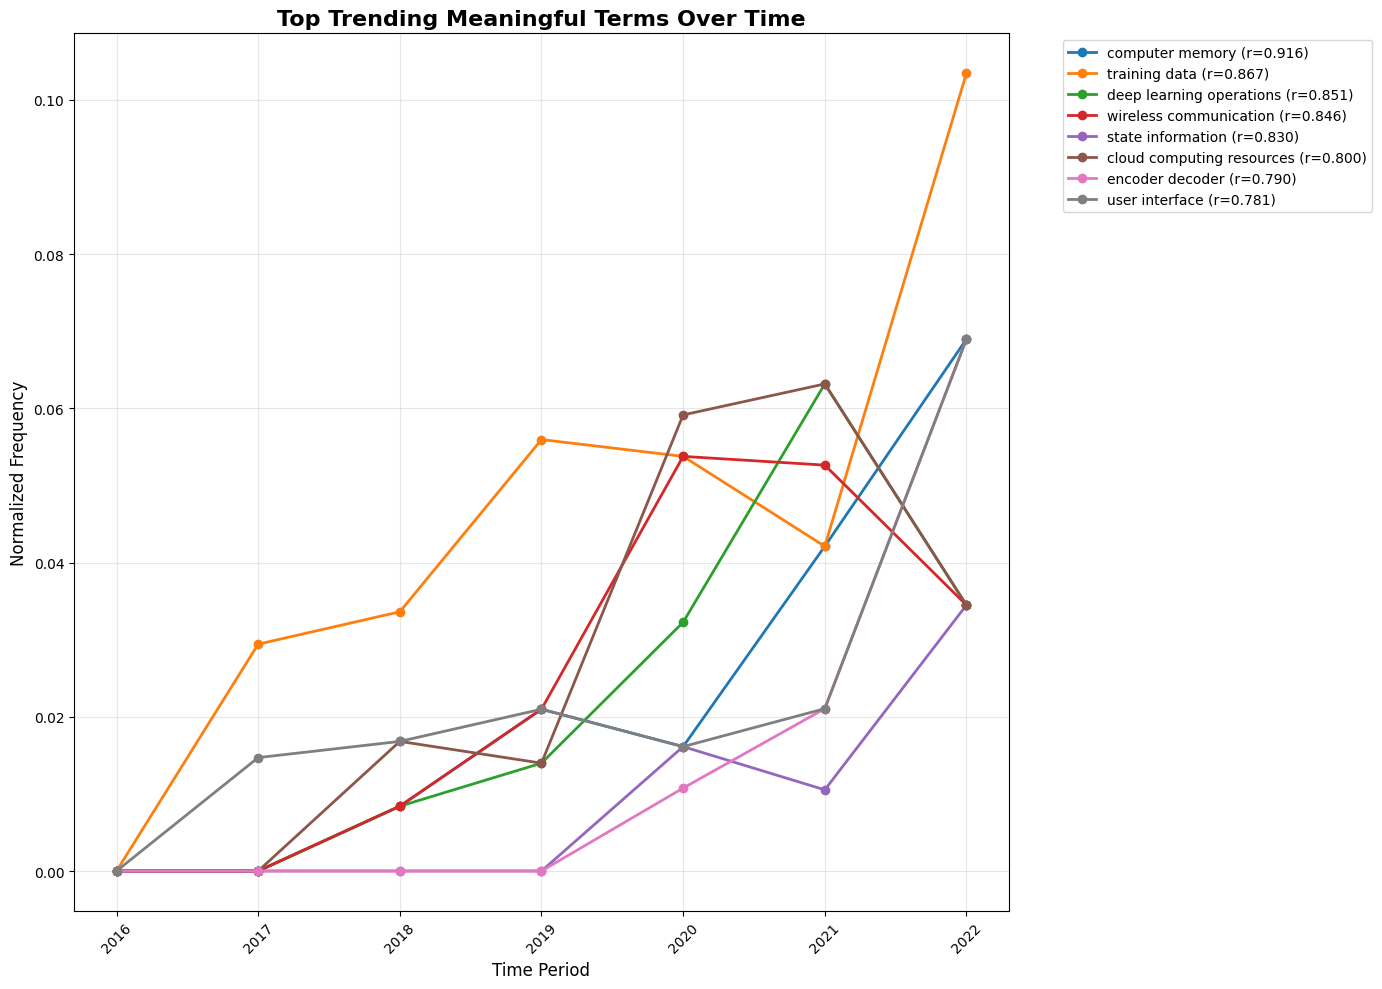

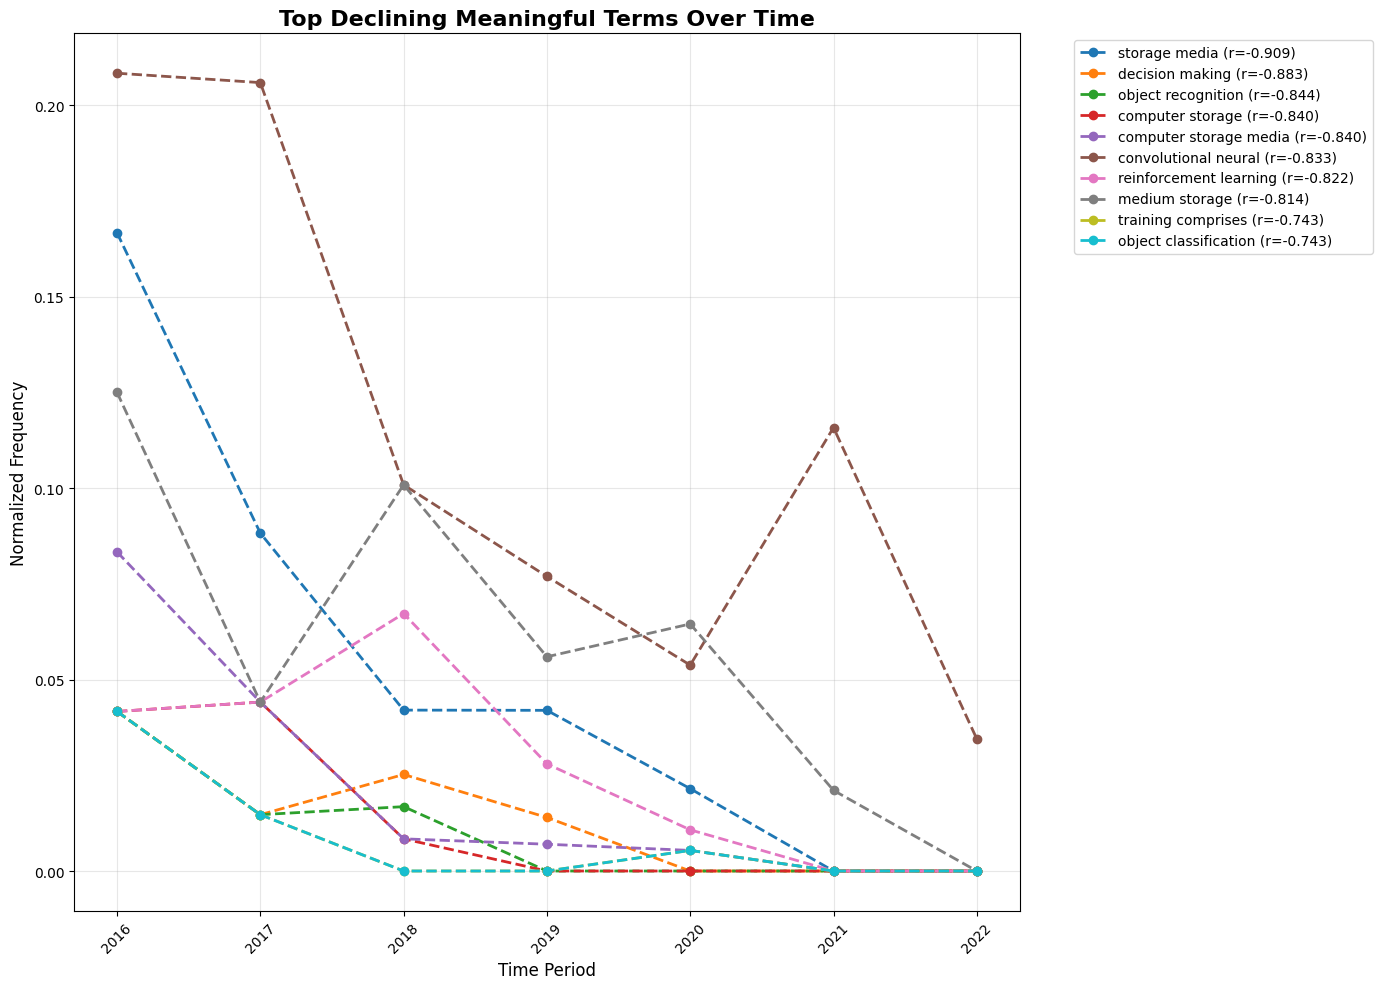

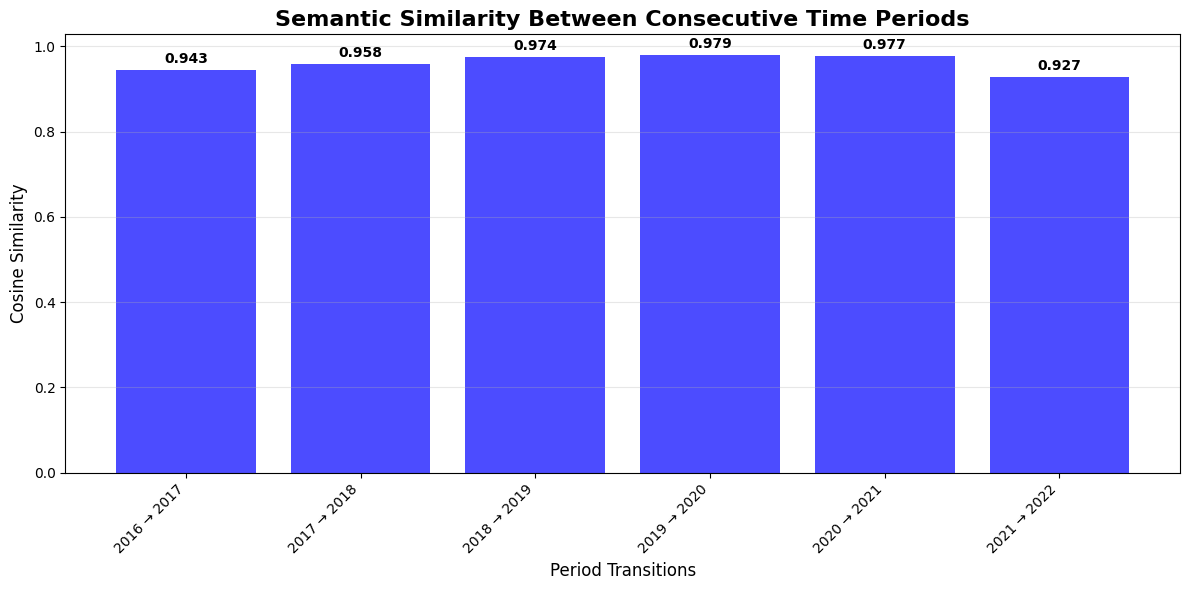

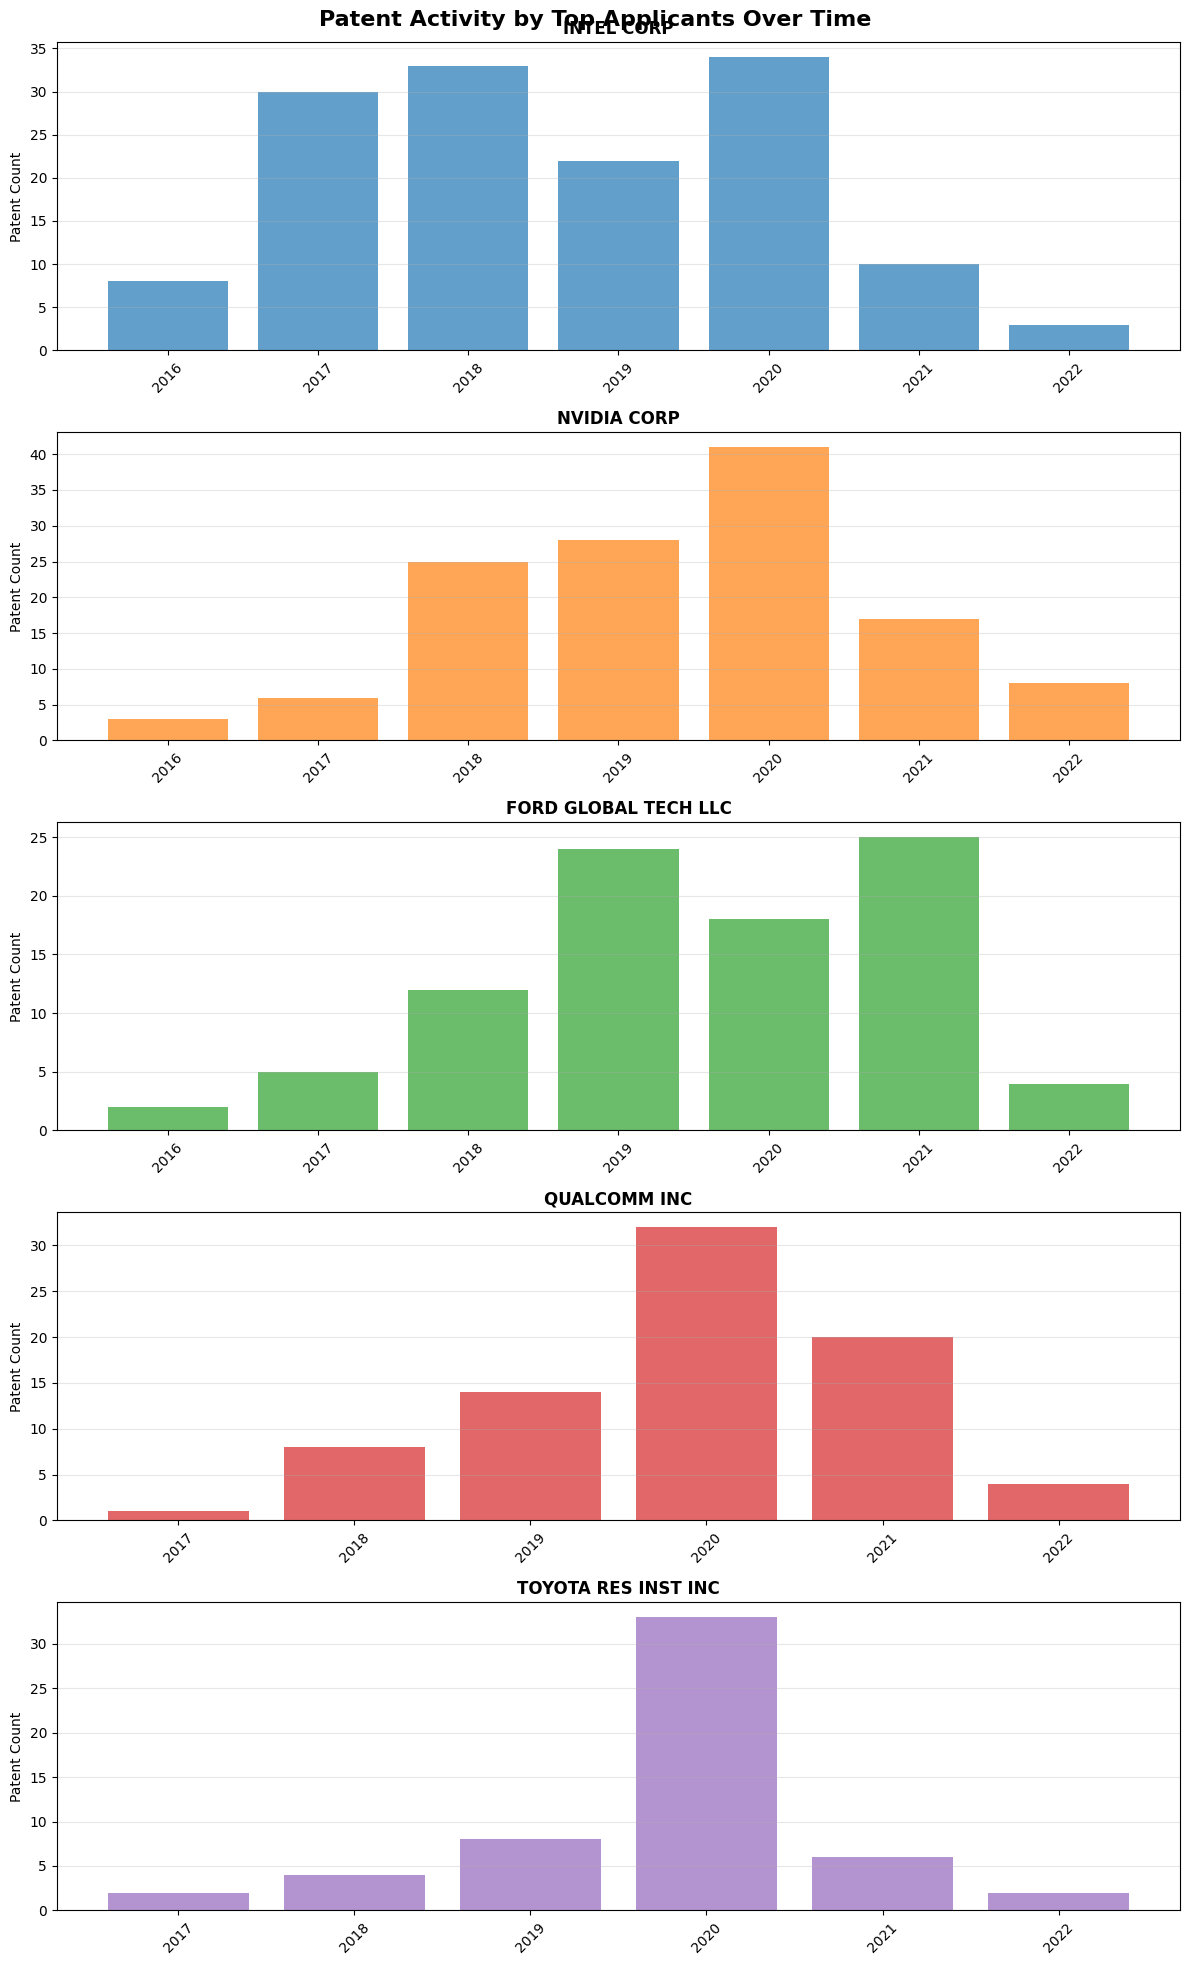

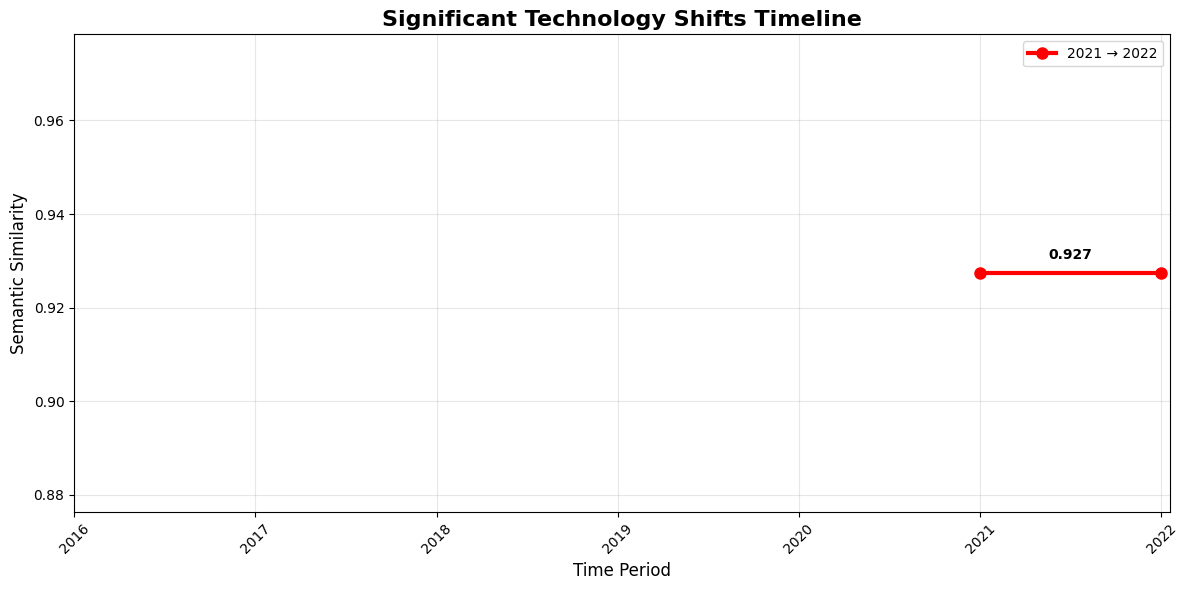

All visualizations generated!

=== ENHANCED INNOVATION TREND ANALYSIS REPORT ===

DATASET OVERVIEW:
Total patents analyzed: 667
Time period: 2014-12-05 to 2022-12-15
Analysis periods: 7 (yearly)
Periods: 2016, 2017, 2018, 2019, 2020, 2021, 2022

MEANINGFUL TERMS ANALYSIS:
Total meaningful terms extracted: 6199
Unique meaningful terms: 4701
Average terms per patent: 9.29

TOP TRENDING MEANINGFUL TERMS:
 1. computer memory                          (r= 0.916, p= 0.004)
 2. training data                            (r= 0.867, p= 0.012)
 3. deep learning operations                 (r= 0.851, p= 0.015)
 4. wireless communication                   (r= 0.846, p= 0.016)
 5. state information                        (r= 0.830, p= 0.021)
 6. cloud computing resources                (r= 0.800, p= 0.031)
 7. encoder decoder                          (r= 0.790, p= 0.035)
 8. user interface                           (r= 0.781, p= 0.038)

TOP DECLINING MEANINGFUL TERMS:
 1. storage media                 

In [ ]:
# Example usage:
if __name__ == "__main__":
    # Initialize analyzer
    analyzer = EnhancedInnovationTrendAnalyzer(
        file_path='/content/av_patentdata.jsonl',
        time_window='yearly',
        min_patents_per_period=10
    )

    # Run complete analysis
    results = analyzer.run_complete_analysis()

    # Example: Get detailed evolution of a specific term
    # evolution = analyzer.get_period_term_evolution('machine learning')
    # if evolution:
    #     print(f"\nEvolution of 'machine learning':")
    #     for period_data in evolution:
    #         print(f"{period_data['period']}: {period_data['patent_count']} patents")